# Exercise 1 - Final report - Computer simulations of stochastic processes

### Report prepered by Anna Szymanek and Maria Kowalczyk in summer semester of academic year 2019/2020.

We will start by preparing all the tools necessary to simulate the risk process, which are: exponential, Pareto, log-normal and Burr random variable generators as well as a homogeneous Poisson process (HPP) generator. For this purpose, where possible, we will use libraries and built-in functions, as well as the inverted cumulative distribution method and the algorithm proposed by Burnecki et al. in the article [1].

In [1196]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
%matplotlib inline

###### Exponential distribution 

The exponential random variable has cumulative distribution function given by: $$F_{X}(x) = 1−e^{(-\beta x)}$$ for $x > 0$, with $β > 0$. To generate random variables from such distribution we will use built-in function.


In [1197]:
def generate_exp(beta, N=1):
    return np.random.exponential(1/beta, N) 

###### Pareto distribution

The Pareto random variable has cumulative distribution function given by: $$F_{X}(x) = 1−\bigg(\frac{\lambda}{\lambda + x}\bigg)^\alpha$$
for $x > 0$, where $\alpha \in (1, 2)$ and $\lambda > 0$. In fact, such distribution is called Lomax distribution.
We will generate Pareto random variables using the inverse transformation method. Let $X$ be a random variable whose distribution can be described by the cumulative distribution function $F_{X}$.
We want to generate values of $X$ which are distributed according to this distribution. It means that we have to generate random number $u$ from the uniform distribution in the interval $[0,1]$, find the inverse of the desired CDF, e.g. $ F_{X}^{-1}(x)$ and compute $X=F_{X}^{-1}(u)$. The computed random variable X has distribution $F_{X}(x)$.

In [1198]:
def generate_pareto(alfa, lbd, N=1):
    u = np.random.uniform(0,1,N)
    x = lbd*(1-(u)**(1/alfa))/(u)**(1/alfa)
    return x

##### Lognormal distribution

The log-normal random variable has cumulative distribution function given by: $$F(x) = \Phi\bigg(\frac{\log{y}-\mu}{\sigma}\bigg)$$
for $x > 0$, where $\Phi(·)$ is normal standard CDF, $\mu \in R$, $\sigma >0.$ To generate random variables from such distribution we will use built-in function.

In [1199]:
def generate_log_norm(mu, sigma, N=1):
    return lognorm.rvs(s=sigma, scale=np.exp(mu), size=N)

##### Burr distribution

The Burr random variable has cumulative distribution function given by: $$F_{X}(x) = 1−\bigg(\frac{\lambda}{\lambda + x^{\tau}}\bigg)^\alpha$$
for $x > 0$, where $\alpha \in (1, 2)$ and $\lambda > 0$, $\tau >0.$ We will generate Burr random variables using the described earlier inverse transformation method. 

In [1200]:
def generate_burr(alfa, lbd, tau, N=1):
    u = np.random.uniform(0,1,N)
    x = (lbd*(1-(u)**(1/alfa))/(u)**(1/alfa))**(1/tau)
    return x

We have to write a function to easily choose claims distribution in further asimulations.

In [1201]:
def claim_distr(x_distr, size, alfa_pareto=1.5, lbd_pareto=0.5, alfa_burr=1.5, lbd_burr=1, tau=1.979,
                beta= 1, mu=-0.6, sigma=np.sqrt(1.2)):
    '''Simulate random variables from chosen distribution.
    
    Parameters:
    x_distr -- claims distribution
    size -- number of generated random variables
    
    Returns:
    vector of claims, theoretical mean of claims'''
    
    if x_distr=='exp':
        X = generate_exp(beta, N=size)
        mean = 1/beta
    elif x_distr=='pareto':
        X = generate_pareto(alfa_pareto, lbd_pareto, N=size)
        mean = lbd_pareto/(alfa_pareto-1)
    elif x_distr == 'lognorm':
        X = generate_log_norm(mu, sigma, N=size)
        mean = np.exp(mu+sigma**2/2)
    elif x_distr == 'burr':
        X = generate_burr(alfa_burr, lbd_burr, tau, N=size)
        mean = 1/gamma(alfa_burr)*lbd_burr**(1/tau)*gamma(1+1/tau)*gamma(alfa_burr-1/tau)
    
    return X, mean 

Parameters should be selected in such a way, that the average is similar for all distributions. Let us check if parameters are set properly.

In [1202]:
_, mean1 = claim_distr('exp', 1)
_, mean2 = claim_distr('pareto', 1)
_, mean3 = claim_distr('lognorm', 1)
_, mean4 = claim_distr('burr', 1)

mean1, mean2, mean3, mean4

(1.0, 1.0, 0.9999999999999999, 1.0032979203138035)

We can see that mean of all distributions is close to 1, so we set parameters rightly.

##### Homogeneous Poisson process

The homogeneous Poisson process denoted by $\{N(t), t\geq 0 \}$ is a stochastic process which can be defined as a counting process. Such a process counts the total number of events that have happened in the interval $(0, t]$. A counting process is a homogeneous Poisson counting process with rate $\lambda >0$ if it has the following three properties:

$\rightarrow N(0)=0,$ 

$\rightarrow$ has independent increments,

$\rightarrow$ the number of events in any interval of length $t$ is a Poisson random variable with parameter (or mean) $\lambda t$.


We will use the following algorithm to simulate the successive arrival times $t_i$ of the Poisson process on the interval $(0,t]$, suggested in article [1]:

Step 1: generate a Poisson random variable N with intensity $\lambda t$

Step 2: generate N random variables $U_i$ distributed uniformly on $(0, 1)$, i.e. $U_i ∼ U(0, 1), i = 1, 2,...,N$

Step 3: set $(t_1, t_2,...,t_N ) = t · \textrm{sort}\{U_1, U_2,\ldots,U_N\}$

In [1203]:
from scipy.stats import poisson

def simulate_hpp(lbd, T): 
    """Simulate homogeneous Poisson Process.
    
    Parameters:
    lbd -- HPP rate
    T -- final simulation time
    
    Returns:
    times of events occurrences, value of HPP after time T 
    """
    N = poisson.rvs(lbd*T, size=1)
    u = np.random.uniform(0,1,N)
    times = T*np.sort(u)
    
    return times, N

##### Risk process simulation

Our first task is to implement a simulation method for the trajectories of the two-dimensional risk process given by 
$$\begin{pmatrix}
U_1(t) \\
U_2(t) 
\end{pmatrix}=
\begin{pmatrix}
u_1 \\
u_2 
\end{pmatrix}+
\begin{pmatrix}
(1+\theta_1)\delta \\
(1+\theta_2)(1-\delta)
\end{pmatrix}\mu\lambda t-
\begin{pmatrix}
\delta \\
1-\delta
\end{pmatrix}
\sum_{k=1}^{N(t)}X_k$$

 up to time $T$ with claims $(X_k)_{k≥1}$ having exponential, Pareto, log-normal and Burr distributions. In the above formula $u_1$ and $u_2$ denote respectively insurer and reinsurer initial capital, $\lambda>0$ denotes homogenous Poisson process intensity, $\theta_1>0$ and $\theta_2>0$ denote respectively insurer and reinsurer relative safety loading and $\delta$ is a splitting parameter $(0<\delta<1)$. Parameters have to meet following assumptions:
$$\frac{u_1}{\delta}<\frac{u_2}{1-\delta}\quad \textrm{and} \quad \theta_1 > (1+\theta_2)^2 - 1 .$$
It is the joint ruin problem for two insurance companies that divide between them both claims and premia in some
specified proportions (for example insurance and reinsurance company), so we assume that insurer and reinsurer agree on a quota-share reinsurance contract for the whole business, which means that there is only one source of claim for both sides and the claims are splited proportionally between insurer and reinsurer with some constant parameter $\delta$. Moreover, if the capital of any insurance company drops below zero, the company goes bankrupt, so the capital is set to zero and remains at this level hereafter.

In [1364]:
from scipy.stats import lognorm

def risk_process(u1=20, u2=20/3, lbd=2, theta1=0.3, theta2=0.03, delta=0.8, x_distr='exp', T=100):
    '''Simulate insurer risk process.
    
    Parameters:
    u1 -- insurer initial capital
    u2 -- reinsurer initial capital
    lbd --  homogenous Poisson process intensity
    theta1 -- insurer relative safety loading (theta1>0)
    theta2 -- reinsurer relative safety loading (theta2>0)
    delta -- splitting parameter (0,1)
    x_distr -- distribution of i.i.d. positive random variables describing claim sizes
    
    Returns:
    Insurer and reinsurer trajectories'''
    
    if u1/delta>=u2/(1-delta) or theta1<=(1+theta2)**2-1:
        raise Exception("Choose another parameters, these don't meet the assumptions.")
        
    hpp_times, hpp_n = simulate_hpp(lbd, T)
    claims, mean = claim_distr(x_distr, hpp_n)
    
    insurer = [u1]
    reinsurer = [u2]
    t = 1
    
    while t<=T:
        
        nr_claims = (hpp_times<=t).sum()
        R1 = u1 + (1+theta1)*delta*mean*lbd*t - delta*sum(claims[:nr_claims])
        insurer.append(R1)
        R2 = u2 + (1+theta2)*(1-delta)*mean*lbd*t - (1-delta)*sum(claims[:nr_claims])
        reinsurer.append(R2)
        t+=1
     
    insurer = np.array(insurer)
    reinsurer = np.array(reinsurer)

    for i, r in enumerate(insurer):
        if r<0:
            insurer[i+1:] = 0
    for i, r in enumerate(reinsurer):
        if r<0:
            reinsurer[i+1:] = 0
            
    return insurer, reinsurer

We will plot several sample trajectories for all four distributions of claims with similar average values, for the same initial values and another parameters values.

In [1365]:
def plot_trajectories(u1, x_distr):
    """Plot trajectories of insurer and reinsurer processes, 
    where reinsurer initial capital is 1/3 of insurer's capital.
    
    Parameters:
    all parameters have the same meaning as in risk_process() function"""
    
    T=100
    u2=u1/3
    r1, r2 = risk_process(u1=u1, u2=u2, x_distr=x_distr)
    plt.plot(np.arange(0,T+1,1), r1, label='insurer')
    plt.plot(np.arange(0,T+1,1), r2, label='reinsurer')
    plt. plot(np.arange(0,T), np.zeros(T), linewidth=0.5, color='red')
    plt.legend()

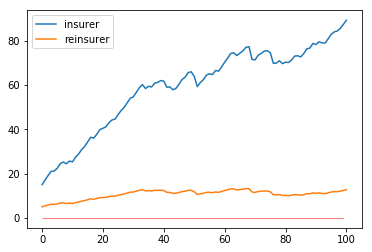

In [1393]:
plot_trajectories(15, x_distr='exp')

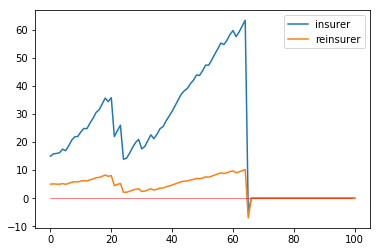

In [1367]:
plot_trajectories(15, x_distr='pareto')

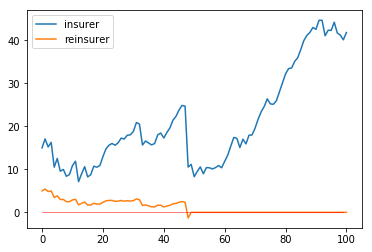

In [1368]:
plot_trajectories(15, x_distr='lognorm')

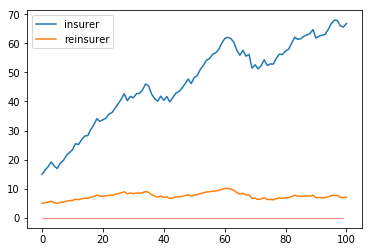

In [1369]:
plot_trajectories(15, x_distr='burr')

Next, we will write a function which checks if for given trajectory the bankruptcy of at least one or both companies occurs. As the process remains at zero after first going below zero, it is enough to check if at any time trajectory goes below zero and use "or" and "and" operators to implement situations that at least one or both companies are in ruin.

In [1379]:
def find_bankruptcy(u1, u2, x_distr, T):
    """Checks if the bankruptcy of at least one or both companies occurs.
    
    Parameters: 
    all parameters have the same meaning as in risk_process() function
    
    Returns:
    tuple, 1 if event (bankruptcy) occured and 0 if event did not occur"""
    
    r1, r2 = risk_process(u1, u2, x_distr=x_distr, T=T)
    if (r1<0).sum()>0 or (r2<0).sum()>0:
        or_bankruptcy = 1
    else:
        or_bankruptcy = 0
    if (r1<0).sum()>0 and (r2<0).sum()>0:
        and_bankruptcy = 1
    else:
        and_bankruptcy = 0

    return or_bankruptcy, and_bankruptcy

Next step is implementing the Monte Carlo method of estimating the ruin probabilities. For this purpose we repeat find_bankruptcy() function MC times, sum its outcome and divide the obtained result by number of Monte Carlo repetitions (MC). 

In [1384]:
def MC_simulation(u1, x_distr='exp', T=1000, MC=100):
    """Conducts Monte Carlo simulations for estimating ruin probabilities.
    
    Parameters:
    u1 and x_distr parameters have the same meaning as in risk_process() function
    T(int) -- time horizon
    MC(int) -- number of Monte Carlo repetitions
    
    Returns:
    Monte Carlo probability that at least one company and that both companies go bankurpt."""
    
    or_sum, and_sum = 0, 0
    u2 = u1/3
    
    for _ in range(MC):
        or_bankruptcy, and_bankruptcy = find_bankruptcy(u1=u1, u2=u2, x_distr=x_distr, T=T)
        or_sum += or_bankruptcy
        and_sum += and_bankruptcy
        
    return or_sum/MC, and_sum/MC

The last task is to plot ruin probabilities as a function of initial capitals, for different claims distributions and time horizons. In order to plot something as a function of initial capitals, we set reinsurer initial capital to be 1/3 of insurer initial capital, so we will plot probabilities as a functions of pairs of initial capitals - $(u_1, \frac{1}{3}u_1)$. In addition we have chosen the range of insurer initial capital $(0, 80)$ and three time horizons: 10, 100 and 1000.

In [1388]:
def plot_probability(x_distr):
    """Plots two graphs for each claims distribution and three lines on each graph for three different time horizons.
    
    Parameters:
    x_distr -- claims distribution"""
    U1 = np.arange(1, 80, 5)
    T = [10, 100, 1000]

    fig, axs = plt.subplots(1,2,figsize=(14,7))
    for t in T:
        or_list = []
        and_list = []
        for u1 in U1:
            or_MC, and_MC = MC_simulation(u1=u1, x_distr=x_distr, T=t, MC=300)
            or_list.append(or_MC)
            and_list.append(and_MC)
            
        
        ax = axs[0]
        ax.plot(U1, or_list, label=f'T={t}')
        ax.set_xlabel('u1')
        ax.set_ylabel('ruin probability')
        ax.legend()
        #ax.set_title(f'ruin probability for claims with {x_distr} distribution')
        ax = axs[1]
        ax.plot(U1, and_list, label=f'T={t}')
        ax.set_xlabel('u1')
        ax.set_ylabel('ruin probability')
        ax.legend()
        #ax.set_title(f'ruin probability for claims with {x_distr} distribution')
        fig.suptitle(f'ruin probabilities ("or", "and") for claims with {x_distr} distribution')
    plt.show()

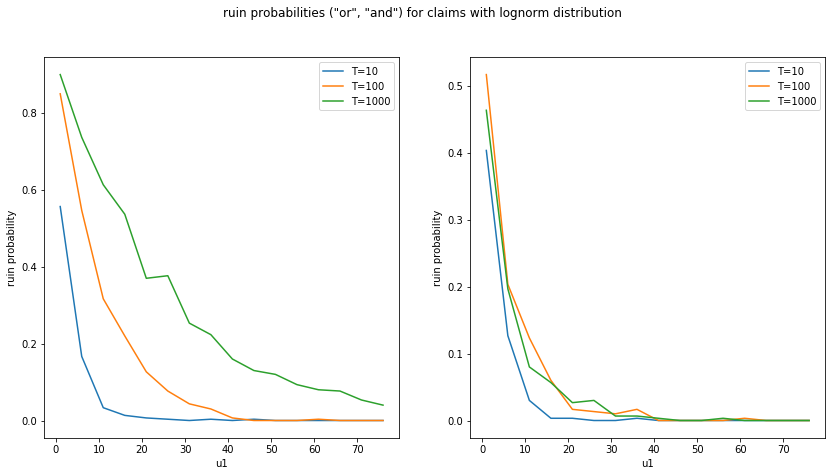

In [1389]:
plot_probability(x_distr='lognorm')

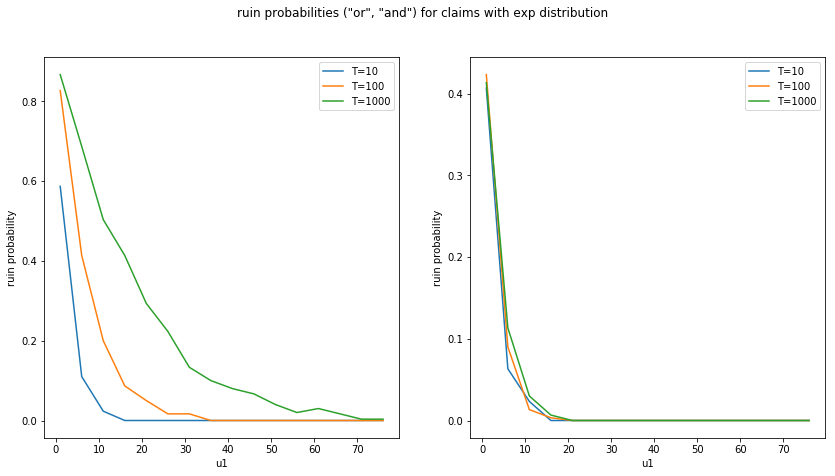

In [1390]:
plot_probability(x_distr='exp')

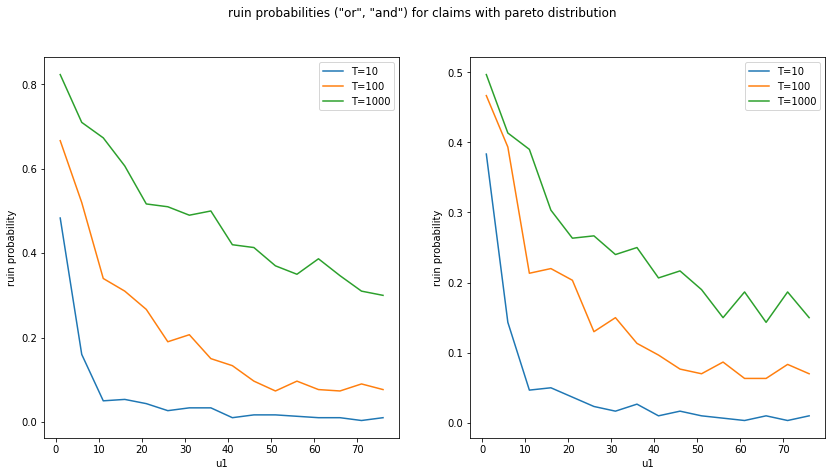

In [1391]:
plot_probability(x_distr='pareto')

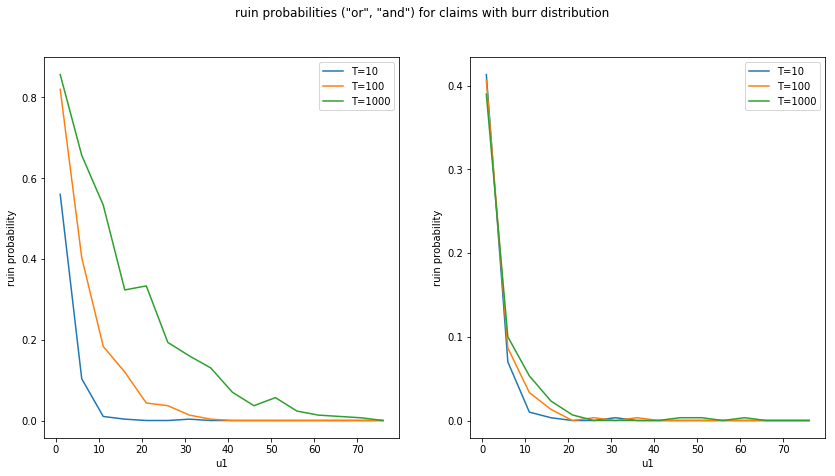

In [1392]:
plot_probability(x_distr='burr')

### Results and conclusions

In this report we implemented a simulation method for the trajectories of the two-dimensional insurer-reinsurer risk process up to time T with claims $(X_k)_{k≥1}$ distributed as:

• an exponential random variable,

• the Pareto random variable,

• a log-normal random variable,

• the Burr random variable.

Then we implemented the Monte Carlo method of estimating the ruin probabilities: probability that the first moment that at least one of the companies is at the ruin is less than T and probability that the first moment that both companies are at the ruin is less than T. Next, we fixed some reasonable parameters of random variables and estimated the ruin probabilities for risk processes with claims having four previously mentioned distributions. Than we determined the initial reinsurer's capital as one-third of the insurer's capital and ploted both types of ruin probability as a function of insurer's initial capital (in range 1:80), for each claim distibution, for three different time horizons: 10, 100 and 1000.

First, quite obvious observation, is that probability that both companies go bankrupt is significantly smaller than probability that at least one of the companies is at the ruin. Moreover, the longer the horizon, the more likely the company will go bankrupt. The last general remark is that the higher the initial capital, the lower the ruin probabilities.

Let us move on to comparing the probability values for different claims distributions. It should be noted that the plots lines are not perfectly smooth due to the number of Monte Carlo repetitions, which was 300. It would be perfect to do thousands of repetitions, but it takes significant computational time. Chosen distributions were log-normal distribution with parameters $\mu=-0.6$ and $\sigma=\sqrt{1.2}$, exponential distribution with parameter $\beta=1$, Pareto (Lomax) distribution with parameters $\alpha=1.5$ and $\lambda=0.5$ and Burr distribution with parameters $\alpha=1.5$, $\lambda=1$ and $\tau=1.979$. All these distributions have mean equal to about 1. What we can see first is that ruin probabilities differ the most for different time horizons when claims have Pareto distribution. For this distribution both probabilities are the biggest for all initial capitals comparing to different claims distributions. Probability that both companies will go bankrupt is the smallest when claims have exponential or Burr distribution. In this case "joint" ruin probability goes from about $50\%$ to very small values close to zero. In case of probability that at least one company will go bankrupt these probability values go from about $80\%$ to very small values close to zero. We do not notice any significant differences between probability behaviour for lognormal, exponential and Burr distributions.

### Bibliography

[1] K. Burnecki, J. Janczura, R. Weron Building loss models in Statistical Tools For Finance and Insurance
(2011), Springer

[2] F. Avram, Z. Palmowski, M. Pistorius A two-dimensional ruin problem on the positive quadrant, Insurance: Mathematics and Economics 42(1) (2008), 227–234.

[3] K. Burnecki, M. Teuerle, A. Wilkowska De Vylder type approximation of the ruin probability for the
insurer-reinsurer model, Mathematica Applicanda 47(1) (2019), 5–24.

[4] K. Burnecki, M. Teuerle Ruin probability in finite time in Statistical Tools For Finance and Insurance
(2011), Springer